## Imports

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pycwt as wavelet
import scipy.constants as const
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import font_manager as fm
from matplotlib.pyplot import MultipleLocator
from pycwt.helpers import find
from pyproj import Transformer as geo_transformer
from scipy.signal import butter, detrend, filtfilt, savgol_filter

In [4]:
import gc
import tomllib
from pathlib import Path
from pprint import pprint

In [5]:
from cartopy.io.img_tiles import OSM

## Baisic Functions

### Geo Coords Transformer & Distance Measurement 

In [6]:
def lla2ecef(lon, lat, alt):
    lla = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84'}
    ecef = {'proj': 'geocent', 'ellps': 'WGS84', 'datum': 'WGS84'}
    transformer = geo_transformer.from_crs(lla, ecef, always_xy=True)
    return transformer.transform(lon, lat, alt, radians=False)


def ecef2lla(x, y, z):
    lla = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84'}
    ecef = {'proj': 'geocent', 'ellps': 'WGS84', 'datum': 'WGS84'}
    transformer = geo_transformer.from_crs(ecef, lla, always_xy=True)
    return transformer.transform(x, y, z, radians=False)


def geo_circle(cenlon, cenlat, r, start, end, geosys=True, km=True, radians=True):
    """r:km, start:radians, end:radians"""
    if geosys:
        cenx, ceny, cenz = lla2ecef(cenlon, cenlat, 0)
        vector = np.array([cenx, ceny, cenz])
        Rearth = np.sqrt(np.dot(vector, vector))
        # print(Rearth)
    else:
        print('geocoords location needed...')
        return None

    if radians:
        pass
    else:
        start = np.radians(start)
        end = np.radians(end)
    DELTA = (end - start) / r / 2.0

    arcs = np.arange(start, end, DELTA)
    arcs = np.append(arcs, arcs[-1] + DELTA)

    if km:
        r *= 1000.0

    deltalon = r * np.sin(arcs) / (Rearth * np.cos(np.radians(cenlat)))
    deltalat = r * np.cos(arcs) / Rearth

    deltalon, deltalat = np.degrees(deltalon), np.degrees(deltalat)
    xpoints, ypoints = cenlon + deltalon, cenlat + deltalat

    return xpoints, ypoints


def geo_line(cenlon, cenlat, r, THETA, nums=10, geosys=True, km=True, radians=True):
    """r:km, start:radians, end:radians"""
    if geosys:
        cenx, ceny, cenz = lla2ecef(cenlon, cenlat, 0)
        vector = np.array([cenx, ceny, cenz])
        Rearth = np.sqrt(np.dot(vector, vector))
        # print(Rearth)
    else:
        print('geocoords location needed...')
        return None

    if radians:
        pass
    else:
        THETA = np.radians(THETA)

    if km:
        r *= 1000

    lines = np.linspace(0, r, nums)

    deltalon = lines * np.sin(THETA) / (Rearth * np.cos(np.radians(cenlat)))
    deltalat = lines * np.cos(THETA) / Rearth

    deltalon, deltalat = np.degrees(deltalon), np.degrees(deltalat)
    xpoints, ypoints = cenlon + deltalon, cenlat + deltalat

    return xpoints, ypoints


def measure_dist_bear_orient(epicenter_ll, IPP_ll, radians=False):
    """units: {distance: km, bearing: radians}"""

    #     radium = 6378+400
    # Height =  400*1000
    Height = 0

    lambda_a, phi_a = epicenter_ll
    if lambda_a < 0:
        lambda_a += 360

    lambda_b, phi_b = IPP_ll
    if lambda_b < 0:
        lambda_b += 360

    x1, y1, z1 = lla2ecef(lambda_a, phi_a, Height)
    x2, y2, z2 = lla2ecef(lambda_b, phi_b, Height)

    vector1 = np.array([x1, y1, z1])
    radium1 = np.sqrt(np.dot(vector1, vector1)) / 1000

    vector2 = np.array([x2, y2, z2])
    radium2 = np.sqrt(np.dot(vector2, vector2)) / 1000

    radium = (radium1 + radium2) / 2
    #     print('radium:', radium)

    if not radians:
        lambda_a = np.radians(lambda_a)
        lambda_b = np.radians(lambda_b)
        phi_a = np.radians(phi_a)
        phi_b = np.radians(phi_b)

    cosine = np.cos(phi_a) * np.cos(phi_b) * np.cos(lambda_a - lambda_b) + np.sin(
        phi_a
    ) * np.sin(phi_b)

    delta = np.arccos(cosine)
    distance = radium * delta

    tangent = (
        np.sin(lambda_b - lambda_a)
        * np.cos(phi_b)
        * np.cos(phi_a)
        / (np.sin(phi_b) - np.sin(phi_a) * cosine)
    )
    bearing = np.arctan2(abs(tangent), 1)

    if lambda_b > lambda_a:
        if phi_b > phi_a:
            bearing = bearing
        elif phi_b < phi_a:
            bearing = np.pi - bearing
        else:
            bearing = np.pi / 2

    elif lambda_b < lambda_a:
        if phi_b > phi_a:
            bearing = 2 * np.pi - bearing
        elif phi_b < phi_a:
            bearing = np.pi + bearing
        else:
            bearing = 3 * np.pi / 2

    else:
        if phi_b >= phi_a:
            bearing = 0
        elif phi_b < phi_a:
            bearing = np.pi

    quarter = np.pi / 4

    if bearing >= 0 and bearing < quarter:
        orientation = 'N.E.'

    elif bearing >= quarter and bearing < 2 * quarter:
        orientation = 'E.N.'

    elif bearing >= 2 * quarter and bearing < 3 * quarter:
        orientation = 'E.S.'

    elif bearing >= 3 * quarter and bearing < 4 * quarter:
        orientation = 'S.E.'

    elif bearing >= 4 * quarter and bearing < 5 * quarter:
        orientation = 'S.W.'

    elif bearing >= 5 * quarter and bearing < 6 * quarter:
        orientation = 'W.S.'

    elif bearing >= 6 * quarter and bearing < 7 * quarter:
        orientation = 'W.N.'

    else:
        orientation = 'N.W.'

    return distance, bearing, orientation

### Time-axis Ticks Formatter

In [7]:
def format_func(x, pos=None):
    x = mdates.num2date(x)
    if x.hour == 0:
        # fmt = '%H\n%b %d'
        fmt = '%H'
    else:
        fmt = '%H'
    label = x.strftime(fmt)

    return label

### New Colormaps

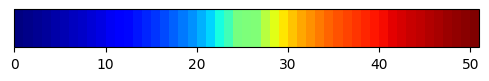

In [8]:
def show_cmap(cmap, norm=None, extend=None):
    """展示一个colormap."""
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=cmap.N)
    im = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    fig.colorbar(im, cax=ax, orientation='horizontal', extend=extend)
    plt.show()


# def new_cmap():
#     nodes = [0,0.05,
#              0.15,
#                 0.45, 0.495,
#                 0.5,
#                 0.505, 0.55,
#                 0.85,
#                 0.95,1]
#     colors = ['darkblue', 'mediumblue',
#               'blue',
#             # 'lightcyan', 'lightcyan',
#             'paleturquoise', 'lightcyan',
#             'honeydew',
#              'lightyellow', 'lemonchiffon',
#             # 'yellow', 'yellow',
#             # 'lightyellow', 'lightyellow',
#             'crimson',
#             'firebrick', 'darkred'
#             ]

#     new_cmap = mcolors.LinearSegmentedColormap.from_list(
#                     'cmap2', list(zip(nodes, colors)))


#     return new_cmap

# nums = 128
nums = 25


# new_cmap1 = new_cmap()
def create_cmap(base=10):
    if base == 10:
        nodes = np.hstack(
            (
                np.log10(np.linspace(10, 1.02, nums)) * (-1),
                0,
                np.log10(np.linspace(1.02, 10, nums)),
            )
        )

    elif base == 2:
        nodes = np.hstack(
            (
                np.log2(np.linspace(2, 1.01, nums)) * (-1),
                0,
                np.log2(np.linspace(1.01, 2, nums)),
            )
        )
    else:
        return None

    nodes += 1
    nodes /= 2
    cmap = cm.jet
    new_cmap = mcolors.ListedColormap(cmap(nodes))
    show_cmap(new_cmap)
    return new_cmap


new_cmap = create_cmap()

## Data & Signal Processing

### Sigal Filters

In [9]:
class Signal(object):
    def __init__(self, signals, sample_rate):
        self.name = 'signals'
        # self.signals = signals
        self.sample_rate = sample_rate

        nan_idx = np.isnan(signals)
        # 找到数组中非 NaN 值的位置
        not_nan_idx = np.logical_not(nan_idx)
        # 使用插值函数 interp() 对 NaN 值进行插值
        signals[nan_idx] = np.interp(
            nan_idx.nonzero()[0], not_nan_idx.nonzero()[0], signals[not_nan_idx]
        )
        self.signals = signals

    def butter_bandpass(self, cut_off_frequency_list, order=5):
        """带通滤波器，需要两个截止频率，以 list 形式输入"""
        self.nyq = 0.5 * self.sample_rate
        normal_cut_off = np.array(cut_off_frequency_list) / self.nyq
        b, a = butter(order, normal_cut_off, btype='bandpass', analog=False)
        return b, a

    def butter_bandpass_filtfilt(self, cut_off_frequency_list, order=5):
        """带通滤波器的执行，消除延迟"""
        b, a = self.butter_bandpass(cut_off_frequency_list, order=order)
        y = filtfilt(b, a, self.signals)
        return y

    def savgol_dtrend_filter(self, winlong, winshort, order=3):
        trend = savgol_filter(self.signals, winlong, order)
        if winshort == 0:
            dtrend = self.signals - trend
            return dtrend
        else:
            dtrend = self.signals - trend
            bandpass = savgol_filter(dtrend, winshort, order)
            return bandpass

## Plots settings

### Basic Maps setting

In [80]:
def set_maps(the_ax, focus_posi, proj, extents, one_arc):
    res = '10m'
    centricx, centricy = focus_posi
    the_ax.add_feature(
        cfeature.LAND.with_scale(res), edgecolor='black', lw=0.12, facecolor='white'
    )
    the_ax.add_feature(cfeature.OCEAN.with_scale(res), facecolor='navy', alpha=0.06)
    the_ax.add_feature(cfeature.BORDERS.with_scale(res), edgecolor='k', lw=0.3)

    the_ax.xaxis.set_major_formatter(LongitudeFormatter())
    the_ax.yaxis.set_major_formatter(LatitudeFormatter())

    # the_ax.scatter(
    #     centric[0], centric[1], c='mediumorchid', transform=proj, s=50, marker='*'
    # )

    minlon, maxlon, minlat, maxlat = extents

    the_ax.set_xticks(
        [round(centricx) - 11, round(centricx), round(centricx) + 11], crs=proj
    )
    the_ax.set_yticks(
        [round(centricy) - 10, round(centricy), round(centricy) + 10], crs=proj
    )
    the_ax.set_extent(extents, crs=proj)

    # one_arc = np.pi / 4.0
    arcs = np.arange(0, 2 * np.pi, one_arc)
    for arc in arcs:
        xpoints, ypoints = geo_line(centricx, centricy, 1000, arc, nums=5)
        the_ax.plot(xpoints, ypoints, c='k', transform=proj, lw=0.3, linestyle='--')

    xpoints, ypoints = geo_circle(centricx, centricy, 500, 0, 2 * np.pi)
    the_ax.plot(xpoints, ypoints, c='crimson', transform=proj, lw=0.5)

    xpoints, ypoints = geo_circle(centricx, centricy, 1000, 0, 2 * np.pi)
    the_ax.plot(xpoints, ypoints, c='navy', transform=proj, lw=0.5)

    the_ax.scatter(
        centricx, centricy, c='crimson', transform=proj, s=70, marker='*', zorder=5
    )

### Travel Time plots

In [81]:
def plot_vars(
    leftx,
    rightx,
    t_range,
    dist,
    notrend,
    site_posi,
    ipp_posi,
    new_cmap,
    vmax=0.7,
    s=5,
    proj=ccrs.PlateCarree(),
    skip=10,
    marker=',',
    alpha=1,
):
    try:
        im = leftx.scatter(
            t_range[::skip],
            [dist] * t_range[::skip].size,
            c=notrend[::skip],
            cmap=new_cmap,
            vmin=-vmax,
            vmax=vmax,
            s=s,
            marker=marker,
            alpha=alpha,
            # extend='both'
        )
    except Exception as e:
        print(e)

    rightx.scatter(site_posi[0], site_posi[1], c='k', transform=proj, s=6, marker='^')
    rightx.scatter(
        ipp_posi[0], ipp_posi[1], c='deepskyblue', transform=proj, s=2, marker='o'
    )
    return im

### Add Speed Line

In [82]:
def add_speed_line(
    ax,
    arrival_t,
    arrival_d,
    dinterval=1 * const.kilo,
    sunit='m/s',
    scalar=0.12,
    xytext=[10, 0],
    lw=1.5,
):
    arrival_t1, arrival_t2 = arrival_t[0], arrival_t[1]
    arrival_d1, arrival_d2 = arrival_d[0], arrival_d[1]
    ranges = arrival_d2 - arrival_d1
    seconds = (arrival_t2 - arrival_t1) / np.timedelta64(1, 's')
    speed = ranges * dinterval / seconds
    str_speed = f'{speed:4.0f}{sunit}'
    ax.plot(
        [arrival_t1, arrival_t2],
        [arrival_d1, arrival_d2],
        color='k',
        lw=lw,
    )
    # scalar = 0.12

    tnote = arrival_t1 + np.timedelta64(int(seconds * scalar), 's')
    rnote = arrival_d1 + ranges * scalar
    ax.annotate(
        str_speed,
        [tnote, rnote],
        xytext=xytext,
        textcoords='offset points',
        fontsize=12,
    )

## Display Types

### Initiation Arguments & Settings 

In [83]:
p_toml = 'earthquake_cases.toml'
event = 'Jishishan'

with open(p_toml, mode='rb') as f_toml:
    case = tomllib.load(f_toml)[event]
    pprint(case)

focus_posi, occur_UT = case['geo_posi'], case['occur_UT']
occur_UT = np.datetime64(occur_UT, 'm')

obs_net = 'CMONOC'
constellation = 'BeiDou'
H_orbit = 35786 * const.kilo
BeiDou_posi = {
    'C01': [140.0, 0, H_orbit],
    'C02': [80.07, 0, H_orbit],
    'C03': [110.45, 0, H_orbit],
    'C04': [159.98, 0, H_orbit],
    'C05': [58.71, 0, H_orbit],
}

t_interval = 1  # unit: second
f_nc = 'datas/BeiDou_TEC_352_01s_2023.nc'
nc = xr.open_dataset(f_nc)
df = pd.read_csv('datas/CMONOC_sites.csv')

{'depth': 10,
 'district': ['China', 'Gansu', 'Linxia', 'Jshishan'],
 'geo_posi': [102.79, 35.7],
 'magnitude': 6.2,
 'occur_UT': '2023-12-18T15:59:30'}


### global font setting

In [84]:
config = {
    'font.family': 'serif',  # sans-serif/serif/cursive/fantasy/monospace
    'font.size': 10,  # medium/large/small
    'font.style': 'normal',  # normal/italic/oblique
    'font.weight': 'bold',  # bold
    # "mathtext.fontset":'stix',# 'cm' (Computer Modern)
    'mathtext.default': 'regular',
    'font.serif': ['Times New Roman'],  # 'Simsun'宋体
    'axes.unicode_minus': False,  # 用来正常显示负号
}
plt.rcParams.update(config)

fonts = fm.FontProperties(family='Times New Roman', weight='bold', size=12)

### Periods: 

#### Sv

In [103]:
def plot_Travel_Time_Diagram_radial(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong=64,
    winshort=60,
    vmax=0.3,
    s=5,
    sv='C02',
    to_save=False,
    mindist=200,  ## unit: km
    maxdist=1000,  ## unit: km
    rows=5,
    start_arc=1,
    one_arc = np.pi / 4.0,   ## unit: radians
    t_start=np.datetime64('2023-12-18T04:00:00'),
    t_end=np.datetime64('2023-12-18T08:00:00'),
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'plots'
    f_save = f'{f_path}/traveltime_radial_{sv}_{label}{winlong}-{winshort}{p_units}.png'

    leftx, rightx = {}, {}
    leftwidth, rightwidth, height, hspace = 0.55, 0.28, 0.076, 0.02

    proj = ccrs.PlateCarree()
    # centric = [focus_posi[0], 35]
    flon, flat = focus_posi[0], focus_posi[1]
    minlon, maxlon, minlat, maxlat = (
        np.floor(flon - 12),
        np.ceil(flon + 12.5),
        np.floor(flat - 9.5),
        np.ceil(flat + 10),
    )
    extents = [minlon, maxlon, minlat, maxlat]
    fig = plt.figure(figsize=(9, 14))
    fig.suptitle(title, x=0.375, y=0.93, fontproperties=fonts)
    for irow in range(rows):
        if irow == 0:
            leftx[irow] = plt.axes(
                [0.10, 0.835 - irow * (height + hspace), leftwidth, height]
            )
            rightx[irow] = plt.axes(
                [0.65, 0.835 - irow * (height + hspace), rightwidth, height],
                projection=proj,
            )
        else:
            leftx[irow] = plt.axes(
                [0.10, 0.835 - irow * (height + hspace), leftwidth, height],
                sharex=leftx[0],
                sharey=leftx[0],
            )
            rightx[irow] = plt.axes(
                [0.65, 0.835 - irow * (height + hspace), rightwidth, height],
                projection=proj,
                sharex=rightx[0],
                sharey=rightx[0],
            )

        set_maps(rightx[irow], focus_posi, proj, extents, one_arc)
        lbullet, rbullet = chr(ord('a') + irow * 2), chr(ord('a') + irow * 2 + 1)
        (
            leftx[irow].set_title(
                f' {lbullet})', loc='left', y=0.8, fontproperties=fonts
            ),
            rightx[irow].set_title(
                f' {rbullet})', loc='left', y=0.8, fontproperties=fonts
            ),
        )

        spine_color = 'k'
        spine_lw = 0.9
        leftx[irow].tick_params(
            axis='both',
            which='both',
            top=True,
            right=True,
            direction='in',
            color='grey',
        )
        rightx[irow].tick_params(
            axis='both',
            top=True,
            right=True,
            direction='in',
            color='grey',
            # width=0.5,
            labelbottom='on',
            labelleft='on',
        )

        leftx[irow].spines['top'].set_linewidth(spine_lw)
        leftx[irow].spines['bottom'].set_linewidth(spine_lw)
        leftx[irow].spines['left'].set_linewidth(spine_lw)
        leftx[irow].spines['right'].set_linewidth(spine_lw)
        rightx[irow].spines['geo'].set_linewidth(spine_lw)

        leftx[irow].spines['top'].set_color(spine_color)
        leftx[irow].spines['bottom'].set_color(spine_color)
        leftx[irow].spines['left'].set_color(spine_color)
        leftx[irow].spines['right'].set_color(spine_color)
        rightx[irow].spines['geo'].set_color(spine_color)

    cbarx = fig.add_axes([0.215, 0.931 - rows * (height + hspace) - 0.051, 0.32, 0.008])
    # site = 'WUHN'
    # for site in obs_sites:

    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(2 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_lon, ipp_lat = (
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        )
        ipp_posi = [ipp_lon, ipp_lat]

        if ipp_lon < minlon:
            continue
        else:
            pass

        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)

        if dist > maxdist:
            continue
        else:
            pass

        
        arc = np.floor((bear - start_arc * one_arc) / one_arc)
        if arc >= rows or arc < 0:
            continue
        else:
            pass

        if sv == 'C02':
            if arc == 1:
                if dist > 920:
                    continue

        vtec = stec * np.cos(zenith)
        ### normalization
        # vtec = Signal(vtec, t_interval)
        # vtec = vtec.savgol_dtrend_filter(2*60*60+1, 5*60+1)
        
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(
            winlong * 60 + 1, winshort * 60 + 1, order=3
        )

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # for irow in range(rows):
        #     rightx[irow].scatter(
        #         site_posi[0], site_posi[1], c='k', transform=proj, s=27, marker='^'
        #     )

        im = plot_vars(
            leftx[arc],
            rightx[arc],
            t_range,
            dist,
            notrend,
            site_posi,
            ipp_posi,
            new_cmap,
            vmax=vmax,
            marker='^',
            s=s,
        )

    cbar = fig.colorbar(
        im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02
    )
    cbar.set_label('DTEC (TECU)', fontproperties=fonts)

    for irow in range(rows):
        leftx[irow].axvline(occur_UT, color='orangered', alpha=0.9, ls='--', lw=2)
        if irow == rows // 2:
            leftx[irow].set_ylabel(
                f'{ylabel} ({v_units})', fontproperties=fonts, labelpad=20
            )

    leftx[0].set_xlim([t_start, t_end])
    leftx[0].set_ylim([mindist, maxdist])
    ticks = np.arange(0, 25, 1)
    mticks = np.arange(0, 70, 10)
    leftx[0].xaxis.set_major_locator(mdates.HourLocator(ticks))
    leftx[0].xaxis.set_minor_locator(mdates.MinuteLocator(mticks))
    leftx[0].xaxis.set_major_formatter(format_func)

    leftx[rows - 1].set_xlabel(f'UT (hour)', fontproperties=fonts)
    # if to_save:
    #     fig.savefig(f_save, bbox_inches='tight')
    # else:
    #     plt.show()
    # plt.clf()
    # plt.close('all')
    # gc.collect()
    return fig, leftx, rightx, f_save

In [104]:
# fig, leftx, rightx, f_save = plot_Travel_Time_Diagram_radial(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong=24,
#     winshort=18,
#     s=5,
#     vmax=0.18,
#     sv='C02',
#     to_save=True,
# )

# for irow in np.arange(1, 5, 1):
#     arrival_t = (
#         np.datetime64('2023-12-18T04:05:00'),
#         np.datetime64('2023-12-18T05:02:00'),
#     )
#     arrival_d = 0, 1000
#     add_speed_line(
#         leftx[irow],
#         arrival_t,
#         arrival_d,
#         dinterval=1 * const.kilo,
#         sunit='m/s',
#         scalar=0.25,
#         xytext=[5, 0.1],
#         lw=1,
#     )

# to_save = True
# if to_save:
#     fig.savefig(f_save, bbox_inches='tight')
# else:
#     plt.show()
# plt.clf()
# plt.close('all')
# gc.collect()

In [105]:
# fig, leftx, rightx, f_save = plot_Travel_Time_Diagram_radial(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong=12,
#     winshort=8,
#     s=6,
#     vmax=0.06,
#     sv='C02',
#     to_save=True,
#     t_start = np.datetime64('2023-12-18T05:00:00'),
#     t_end = np.datetime64('2023-12-18T07:00:00')
# )

# for irow in np.arange(5):
#     arrival_t = (
#             np.datetime64('2023-12-18T05:42:00'),
#             np.datetime64('2023-12-18T06:02:00'),
#         )
#     arrival_d = 0, 1000
#     add_speed_line(
#         leftx[irow],
#         arrival_t,
#         arrival_d,
#         dinterval=1 * const.kilo,
#         sunit='m/s',
#         scalar=0.2,
#         xytext=[10, 0.1],
#         lw=1,
#     )
#     if irow >= 1:
#         arrival_t = (
#             np.datetime64('2023-12-18T04:05:00'),
#             np.datetime64('2023-12-18T04:40:00'),
#         )
#         arrival_d = 0, 1000
#         add_speed_line(
#             leftx[irow],
#             arrival_t,
#             arrival_d,
#             dinterval=1 * const.kilo,
#             sunit='m/s',
#             scalar=0.25,
#             xytext=[5, 0.1],
#             lw=1,
#         )

# to_save = True
# if to_save:
#     fig.savefig(f_save, bbox_inches='tight')
# else:
#     plt.show()
# plt.clf()
# plt.close('all')
# gc.collect()

In [106]:
# fig, leftx, rightx, f_save = plot_Travel_Time_Diagram_radial(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong=20,
#     winshort=18,
#     s=4,
#     vmax=0.2,
#     sv='C01',
#     to_save=True,
#     maxdist=1000,
#     mindist=100,
#     rows=3,
# )

# for irow in np.arange(3):
#     arrival_t = (
#         np.datetime64('2023-12-18T04:05:00'),
#         np.datetime64('2023-12-18T04:40:00'),
#     )
#     arrival_d = 0, 1000
#     add_speed_line(
#         leftx[irow],
#         arrival_t,
#         arrival_d,
#         dinterval=1 * const.kilo,
#         sunit='m/s',
#         scalar=0.8,
#         xytext=[5, 0.1],
#         lw=1,
#     )

#     if irow >= 1:
#         arrival_t = (
#             np.datetime64('2023-12-18T04:20:00'),
#             np.datetime64('2023-12-18T05:40:00'),
#         )
#         arrival_d = 0, 1000
#         add_speed_line(
#             leftx[irow],
#             arrival_t,
#             arrival_d,
#             dinterval=1 * const.kilo,
#             sunit='m/s',
#             scalar=0.8,
#             xytext=[10, 0.1],
#             lw=1,
#         )

# to_save = True
# if to_save:
#     fig.savefig(f_save, bbox_inches='tight')
# else:
#     plt.show()
# plt.clf()
# plt.close('all')
# gc.collect()

In [112]:
# fig, leftx, rightx, f_save = plot_Travel_Time_Diagram_radial(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong=24,
#     winshort=20,
#     s=7,
#     vmax=0.1,
#     sv='C03',
#     to_save=True,
#     maxdist=1000,
#     mindist=0,
#     rows=7,
#     start_arc=2,
#     one_arc = np.pi / 6.0,  ## unit: radians
#     t_start= np.datetime64('2023-12-18T03:00:00')
# )

# for irow in np.arange(7):
#     arrival_t = (
#             np.datetime64('2023-12-18T04:40:00'),
#             np.datetime64('2023-12-18T05:24:00'),
#         )
#     arrival_d = 0, 1000
#     add_speed_line(
#         leftx[irow],
#         arrival_t,
#         arrival_d,
#         dinterval=1 * const.kilo,
#         sunit='m/s',
#         scalar=0,
#         xytext=[10, 0.1],
#         lw=1,
#     )
#     # if irow >= 1:
#     arrival_t = (
#         np.datetime64('2023-12-18T03:20:00'),
#         np.datetime64('2023-12-18T03:40:00'),
#     )
#     arrival_d = 0, 1000
#     add_speed_line(
#         leftx[irow],
#         arrival_t,
#         arrival_d,
#         dinterval=1 * const.kilo,
#         sunit='m/s',
#         scalar=0,
#         xytext=[10, 0.1],
#         lw=1,
#     )

# to_save = True
# if to_save:
#     fig.savefig(f_save, bbox_inches='tight')
# else:
#     plt.show()
# plt.clf()
# plt.close('all')
# gc.collect()

81581

In [122]:
fig, leftx, rightx, f_save = plot_Travel_Time_Diagram_radial(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong=12,
    winshort=8,
    s=9,
    vmax=0.05,
    sv='C03',
    to_save=True,
    maxdist=1000,
    mindist=0,
    rows=7,
    start_arc=2,
    one_arc = np.pi / 6.0,  ## unit: radians
    t_start= np.datetime64('2023-12-18T03:00:00'),
    t_end= np.datetime64('2023-12-18T06:00:00')
)

for irow in np.arange(7):
    # arrival_t = (
    #         np.datetime64('2023-12-18T04:40:00'),
    #         np.datetime64('2023-12-18T05:24:00'),
    #     )
    # arrival_d = 0, 1000
    # add_speed_line(
    #     leftx[irow],
    #     arrival_t,
    #     arrival_d,
    #     dinterval=1 * const.kilo,
    #     sunit='m/s',
    #     scalar=0,
    #     xytext=[10, 0.1],
    #     lw=1,
    # )
    # if irow >= 1:
    arrival_t = (
        np.datetime64('2023-12-18T03:20:00'),
        np.datetime64('2023-12-18T03:40:00'),
    )
    arrival_d = 0, 1000
    add_speed_line(
        leftx[irow],
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0,
        xytext=[10, 0.1],
        lw=1,
    )

to_save = True
if to_save:
    fig.savefig(f_save, bbox_inches='tight')
else:
    plt.show()
plt.clf()
plt.close('all')
gc.collect()

71990